In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from trixi.util import Config
import pickle
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from experiment import CelebAExperiment
from deliverables import display_img_samples

%load_ext autoreload
%autoreload 2


# RealNVP on low quality CelebA HQ
## Data inspection



In [2]:
with open('hw2_q2.pkl', 'rb') as f:
    data = pickle.load(f)

train_data = data['train']
test_data = data['test']
pxl_max = train_data.max()


In [3]:
train_data = torch.tensor(train_data).index_select(-1, torch.arange(2, -1, -1))
test_data = torch.tensor(test_data).index_select(-1, torch.arange(2, -1, -1))
train_loader = DataLoader(train_data, batch_size=10)


In [5]:
batch = next(iter(train_loader))


torch.Size([10, 32, 32, 3])
torch.Size([10, 32, 32, 3])


In [ ]:
for i, img in enumerate(train_loader):
    if i % 100 > 0:
        continue
    if i > 1000:
        break
    grid = make_grid(img.permute(0, 3, 1,2), nrow=5)
    plt.figure(figsize=(10, 10))
    img = (grid.permute(1, 2, 0).float() / pxl_max)
    plt.imshow(img)
    

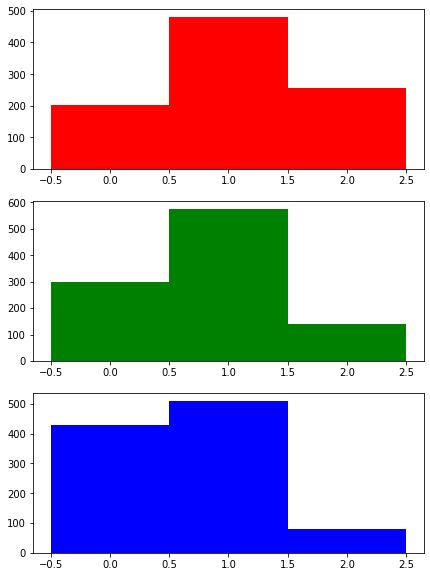

In [7]:
example = train_data[20]
plt.figure(figsize=(7, 10))
plt.subplot(311)
h = plt.hist(example[..., 0].flatten(), bins=np.arange(4) - .5, color='r', )
plt.subplot(312)
h = plt.hist(example[..., 1].flatten(), bins=np.arange(4) - .5, color='g', )
plt.subplot(313)
h = plt.hist(example[..., 2].flatten(), bins=np.arange(4) - .5, color='b', )


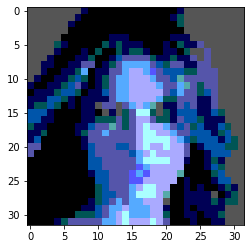

In [8]:
example = train_data[4].clone()
example2 = example.clone()
r = example2[..., 0]
g = example2[..., 1]
b = example2[..., 2]
example[..., 0] = b
example[..., 1] = g
example[..., 2] = r
plt.imshow(example.float() / pxl_max)

Apparently, the R and B channels were swapped during the creation of the dataset (see above for how the images looked like without correction).

As a next step, we need to dequantize the images, so that the pixels are not discrete valued any more. Best practice is to add uniform noise from [0, 1[
to the integer values and normalize afterwards.

In [17]:
def dequantize(imgs, max_val=3):
    real_imgs = imgs.float() + torch.rand(imgs.size())
    return real_imgs / (max_val + 1)

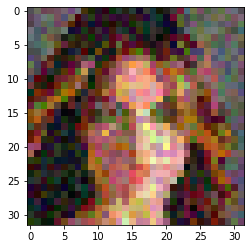

In [19]:
d = dequantize(train_data[4])
plt.imshow(d)


## Model Evaluation


In [2]:
c = Config()

c.batch_size = 32
c.n_epochs = 2
c.learning_rate = 0.001
if torch.cuda.is_available():
    c.use_cuda = True
else:
    c.use_cuda = False
c.rnd_seed = 1
c.log_interval = 200
# model-specific
c.n_coupling = 6
c.n_filters = 256

resume_dir = 'experiment_dir/20190821-140536_test'
exp = CelebAExperiment(c, name='test', n_epochs=c.n_epochs, seed=42, base_dir='experiment_dir',
                       resume=resume_dir, resume_save_types=['model'],
                       loggers={'visdom': ['visdom', {"exp_name": "myenv"}]})


In [3]:
exp.setup()
exp._setup_internal()


Config:
{
    "base_dir": "experiment_dir",
    "batch_size": 32,
    "learning_rate": 0.001,
    "log_interval": 200,
    "n_coupling": 6,
    "n_epochs": 2,
    "n_filters": 256,
    "name": "test",
    "rnd_seed": 1,
    "seed": 42,
    "use_cuda": true
}
Experiment set up.
Loaded existing config from: experiment_dir/20190821-140536_test
Loaded existing checkpoint from: experiment_dir/20190821-140536_test/checkpoint/checkpoint_current.pth.tar


INFO:default-kUwmEiZn5I:Config:
INFO:default-kUwmEiZn5I:{
    "base_dir": "experiment_dir",
    "batch_size": 32,
    "learning_rate": 0.001,
    "log_interval": 200,
    "n_coupling": 6,
    "n_epochs": 2,
    "n_filters": 256,
    "name": "test",
    "rnd_seed": 1,
    "seed": 42,
    "use_cuda": true
}
INFO:default-kUwmEiZn5I:Experiment set up.
INFO:default-kUwmEiZn5I:Loaded existing config from: experiment_dir/20190821-140536_test
INFO:default-kUwmEiZn5I:Loaded existing checkpoint from: experiment_dir/20190821-140536_test/checkpoint/checkpoint_current.pth.tar


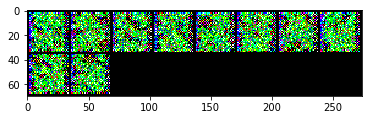

In [5]:
exp.model.eval()
exp.model.to('cpu')
# d = torch.tensor(test_data, dtype=torch.float32)
# show_density_2d(exp.model)
# with torch.no_grad():
#     z = exp.model(d)[0].detach()
# display_latent_vars(z, test_targets)
# samples = display_img_samples(exp.model, 16)
with torch.no_grad():

    # generate samples from z distribution
    z = torch.randn(10, 3, 32, 32)
    # apply inverse flow to get samples for x
    samples = exp.model.inv_flow(z)
    img_grid = make_grid(samples).permute((1, 2, 0))
plt.imshow(img_grid)
plt.show()


ValueError: supplied range of [-inf, inf] is not finite

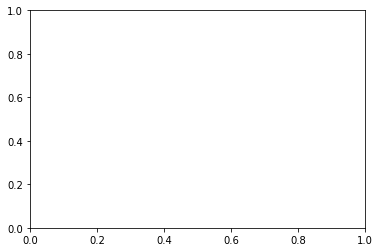

In [6]:
h = plt.hist(samples.flatten()) 
